#  Business Objective:-

####  Data provided is related to USD/INR Exchange rates. The objective is to understand the underlying structure in your dataset and come up with a suitable forecasting model which can effectively forecast USD/INR exchange rate for next 30 days. This forecast model will be used by exporting and importing companies to understand the currency movements and accordinglyset their revenue expectations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
warnings.filterwarnings("ignore")

In [2]:
#import the dataset
df=pd.read_excel("C:/Users/haris/Downloads/project-p63/DEXINUS.xlsx",skiprows=range(10))
df

,observation_date,DEXINUS
0,1973-01-02,8.02
1,1973-01-03,8.02
2,1973-01-04,8.00
3,1973-01-05,8.01
4,1973-01-08,8.00
...,...,...
12644,2021-06-21,74.18
12645,2021-06-22,74.37
12646,2021-06-23,74.13
12647,2021-06-24,74.14


# EDA

In [3]:
#change the column name
df=df.rename({'observation_date':'DATE','DEXINUS':'RATE'},axis=1)

In [4]:
df

,DATE,RATE
0,1973-01-02,8.02
1,1973-01-03,8.02
2,1973-01-04,8.00
3,1973-01-05,8.01
4,1973-01-08,8.00
...,...,...
12644,2021-06-21,74.18
12645,2021-06-22,74.37
12646,2021-06-23,74.13
12647,2021-06-24,74.14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12649 entries, 0 to 12648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    12649 non-null  datetime64[ns]
 1   RATE    12155 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 197.8 KB


In [6]:
df.isnull().sum()  #494 null value

DATE      0
RATE    494
dtype: int64

In [7]:
df.shape  

(12649, 2)

In [8]:
df.describe()

,RATE
count,12155.000000
mean,34.206133
std,21.089190
min,7.190000
25%,12.075000
50%,35.890000
75%,47.650000
max,76.950000


In [9]:
df.fillna(method='ffill',inplace=True)

In [10]:
df.isnull().sum()

DATE    0
RATE    0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
df.dtypes

DATE    datetime64[ns]
RATE           float64
dtype: object

In [13]:
df['t']=np.arange(1,len(df)+1)

In [14]:
df['MONTH']=df.DATE.dt.strftime("%b")
df['YEAR']=df.DATE.dt.strftime("%y")

In [15]:
df['t_sqrt']=df['t']**2

In [16]:
df['log_RATE']=np.log(df['RATE'])

In [17]:
month_dummies=pd.DataFrame(pd.get_dummies(df['MONTH']))
df=pd.concat([df,month_dummies],axis=1)

In [18]:
df.head()

,DATE,RATE,t,MONTH,YEAR,t_sqrt,log_RATE,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1973-01-02,8.02,1,Jan,73,1,2.081938,0,0,0,0,1,0,0,0,0,0,0,0
1,1973-01-03,8.02,2,Jan,73,4,2.081938,0,0,0,0,1,0,0,0,0,0,0,0
2,1973-01-04,8.00,3,Jan,73,9,2.079442,0,0,0,0,1,0,0,0,0,0,0,0
3,1973-01-05,8.01,4,Jan,73,16,2.080691,0,0,0,0,1,0,0,0,0,0,0,0
4,1973-01-08,8.00,5,Jan,73,25,2.079442,0,0,0,0,1,0,0,0,0,0,0,0


In [19]:
test = df.copy()
test.set_index('DATE',inplace = True)
test

,RATE,t,MONTH,YEAR,t_sqrt,log_RATE,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
DATE,,,,,,,,,,,,,,,,,,
1973-01-02,8.02,1,Jan,73,1,2.081938,0,0,0,0,1,0,0,0,0,0,0,0
1973-01-03,8.02,2,Jan,73,4,2.081938,0,0,0,0,1,0,0,0,0,0,0,0
1973-01-04,8.00,3,Jan,73,9,2.079442,0,0,0,0,1,0,0,0,0,0,0,0
1973-01-05,8.01,4,Jan,73,16,2.080691,0,0,0,0,1,0,0,0,0,0,0,0
1973-01-08,8.00,5,Jan,73,25,2.079442,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,74.18,12645,Jun,21,159896025,4.306495,0,0,0,0,0,0,1,0,0,0,0,0
2021-06-22,74.37,12646,Jun,21,159921316,4.309053,0,0,0,0,0,0,1,0,0,0,0,0
2021-06-23,74.13,12647,Jun,21,159946609,4.305820,0,0,0,0,0,0,1,0,0,0,0,0


# data visualization

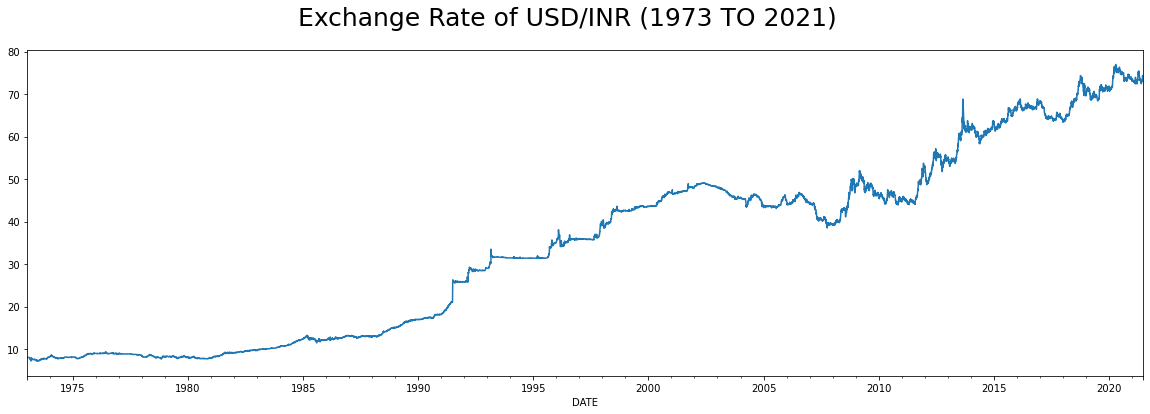

In [15]:
#plot all data
plt.figure(figsize=(20,6))
plt.suptitle('Exchange Rate of USD/INR (1973 TO 2021)' ,size=25)
df['RATE'].plot()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1af5161b280>,
 'caps': [<matplotlib.lines.Line2D at 0x1af5161b940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1af51607ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x1af51629040>],
 'fliers': [<matplotlib.lines.Line2D at 0x1af516293a0>],
 'means': []}

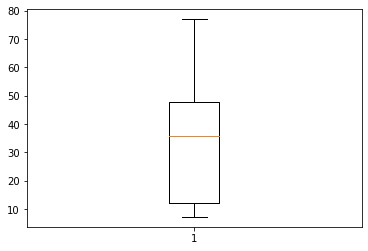

In [15]:
plt.boxplot(df['RATE'])

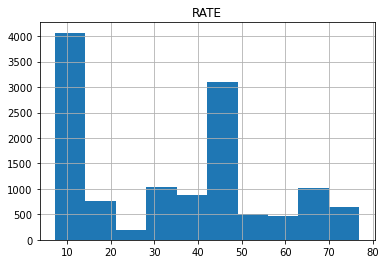

In [16]:
df.hist('RATE')
plt.show()        #histogram

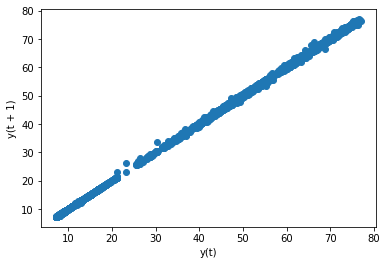

In [17]:
lag_plot(df['RATE'])    #lag plot
plt.show()

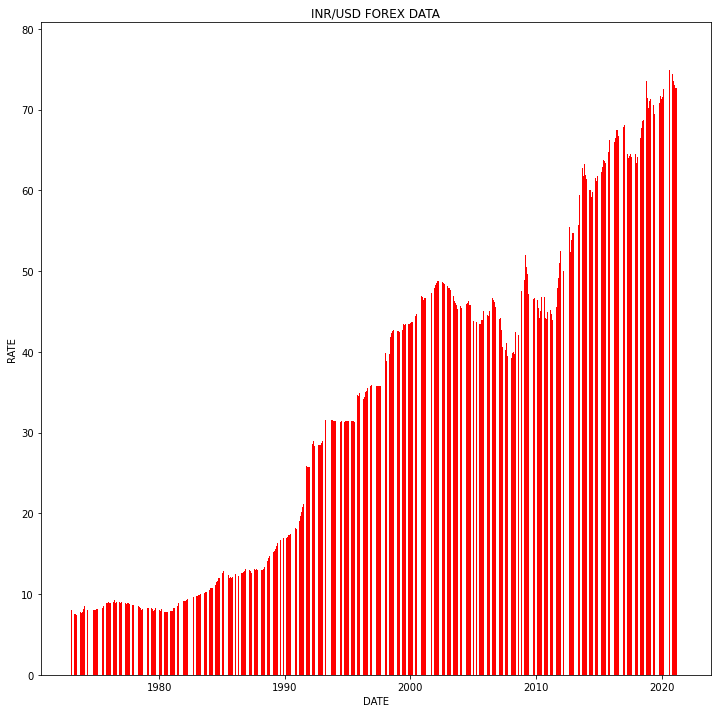

In [18]:
#bar plot
fig,ax = plt.subplots(figsize=(12,12))
ax.bar(df['DATE'],df['RATE'],color='red')
ax.set(xlabel='DATE',ylabel='RATE',title='INR/USD FOREX DATA')
plt.show()

{'bodies': [<matplotlib.collections.PolyCollection at 0x1af59aaf490>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1af59aafbb0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1af59abf910>,
 'cbars': <matplotlib.collections.LineCollection at 0x1af59aafbe0>}

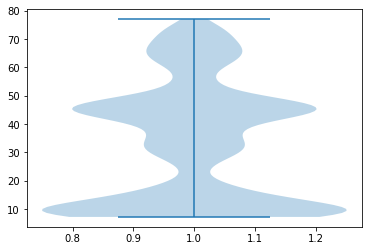

In [19]:
plt.violinplot(df['RATE'])

<AxesSubplot:xlabel='DATE', ylabel='RATE'>

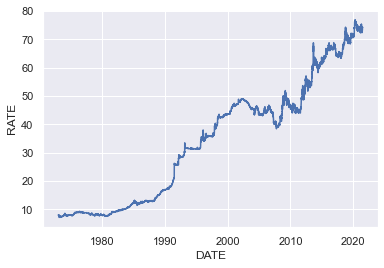

In [20]:
x=df['DATE']
y=df['RATE']
sns.set_theme(style='darkgrid')
sns.lineplot(x='DATE',y='RATE',data=df)

<AxesSubplot:xlabel='YEAR', ylabel='RATE'>

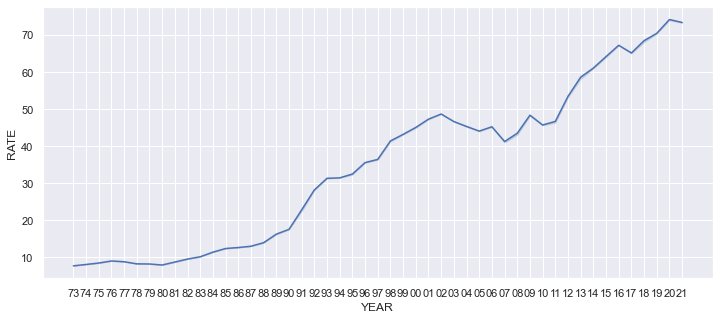

In [21]:
plt.figure(figsize=(12,5))                  #line plot
sns.lineplot(x='YEAR',y='RATE',data=df)

<AxesSubplot:xlabel='MONTH', ylabel='YEAR'>

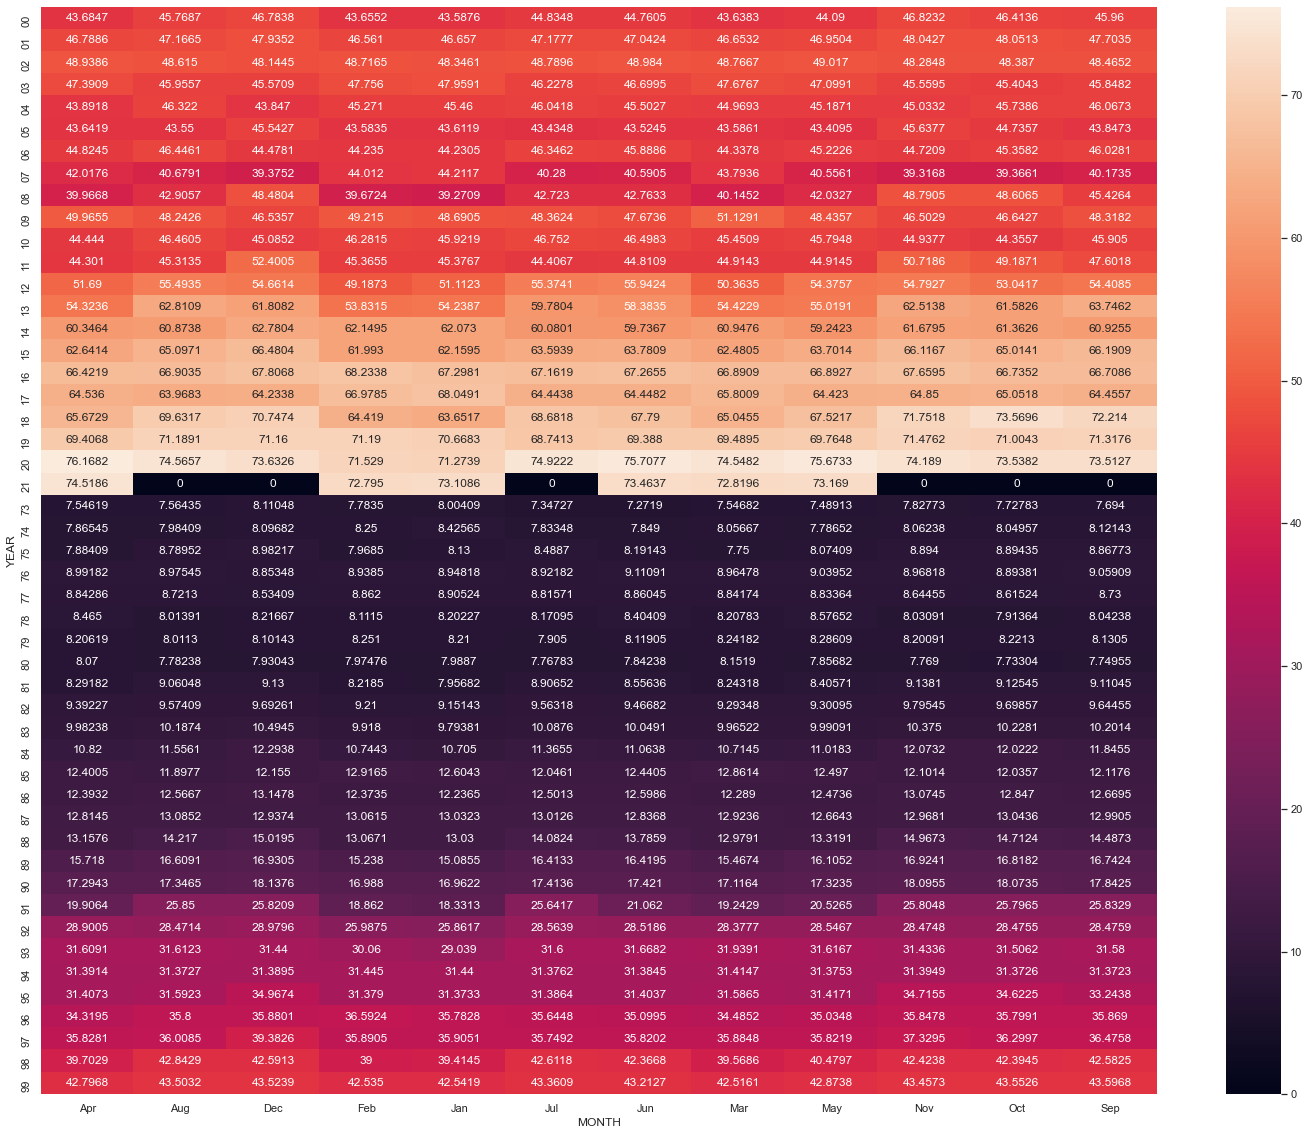

In [22]:
#heat map
plt.figure(figsize=(25,20))
heatmap_YEAR_MONTH=pd.pivot_table(data=df,values='RATE',index='YEAR',columns='MONTH',aggfunc='mean',fill_value=0)
sns.heatmap(heatmap_YEAR_MONTH,annot=True,fmt='g')

<AxesSubplot:xlabel='YEAR', ylabel='RATE'>

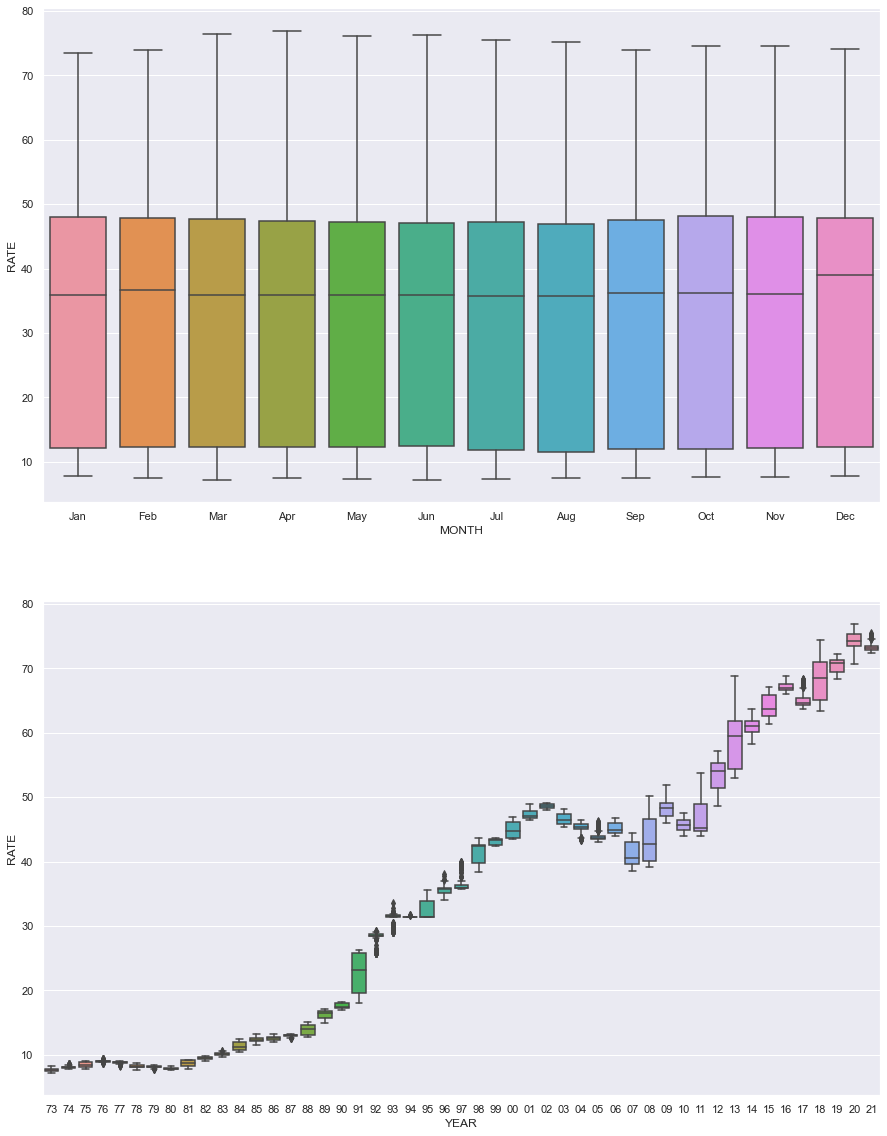

In [23]:
#box plot
plt.figure(figsize=(15,20))
plt.subplot(211)
sns.boxplot(x='MONTH',y='RATE',data=df)
plt.subplot(212)
sns.boxplot(x='YEAR',y='RATE',data=df)

<AxesSubplot:ylabel='Count'>

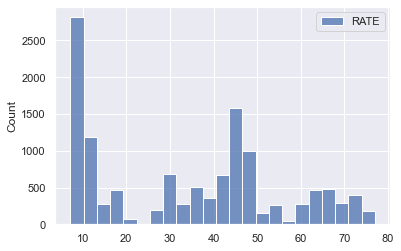

In [24]:
sns.histplot(data=df)

<AxesSubplot:ylabel='Density'>

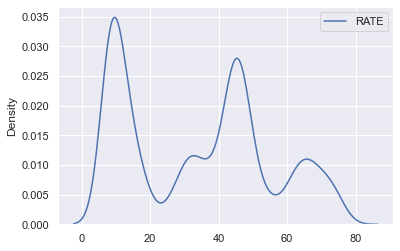

In [25]:
#kernel density plot
sns.kdeplot(data=df)

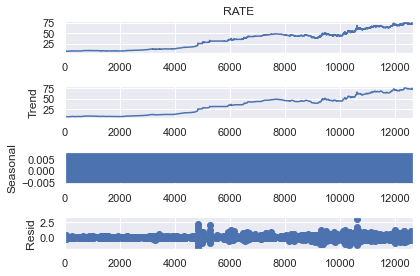

In [26]:
#time series decomposition plot
decompose_ts_add = seasonal_decompose(df['RATE'],period=12)
decompose_ts_add.plot()
plt.show()

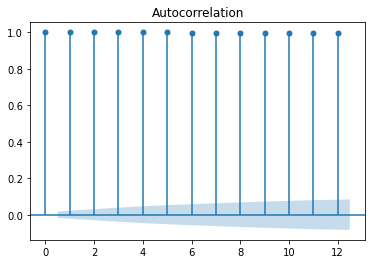

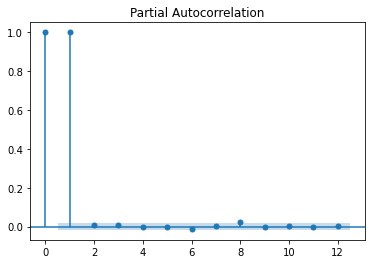

In [23]:
#acf & pacf plot
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df['RATE'],lags=12)
tsa_plots.plot_pacf(df['RATE'],lags=12)
plt.show()

# stationary

In [ ]:
#first we will check data is stationary or not.
#if data is not stationary then convert to stationary.
#check stationary or not by dividing the data and check mean and variance

In [20]:
x=df['RATE']
y=round(len(x)/2)
x1,x2=x[0:y],x[y:]
mean1,mean2=x1.mean(),x2.mean()
var1,var2=x1.var(),x2.var()
print('mean1=%f,mean2=%f'%(mean1,mean2))
print('variance1=%f,variance2=%f'%(var1,var2))

mean1=15.734203,mean2=52.677101
variance1=86.603026,variance2=122.512037


In [21]:
#ADF TEST
from statsmodels.tsa.stattools import adfuller
#if p<=0.05,it is stationary.if p>0.05 it is not stationary
x=df['RATE']
result=adfuller(x)
print('adf statistic:%f'%result[0])
print('p-value:%f'%result[1])

adf statistic:0.632001
p-value:0.988378


<AxesSubplot:>

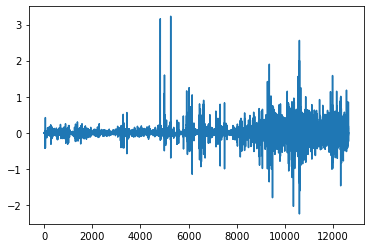

In [22]:
df['RATE-diff']=df['RATE']-df['RATE'].shift(1)
df['RATE-diff'].dropna().plot()

<AxesSubplot:>

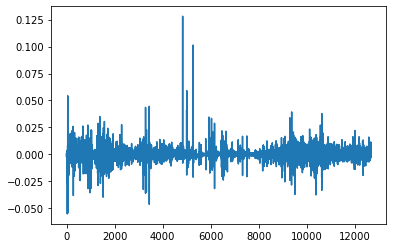

In [23]:
#transformation method
#by applying log transform & difference on our dataset & plotting the result
df['RATE-log']=np.log(df['RATE'])
df['RATE-log-diff']=df['RATE-log']-df['RATE-log'].shift(1)
df['RATE-log-diff'].dropna().plot()

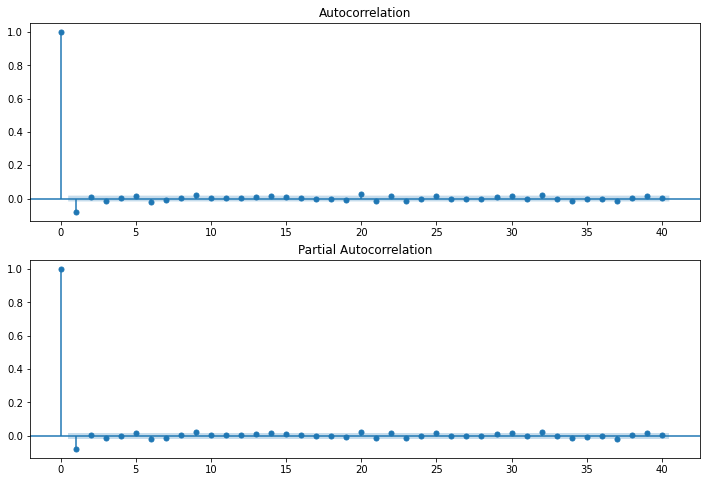

In [24]:
#acf and pacf plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)    #matplotlb axis object
fig = sm.graphics.tsa.plot_acf(df['RATE-log-diff'].iloc[2:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['RATE-log-diff'].iloc[2:], lags=40, ax=ax2)

#### As we can see,this plot is a significant improvement over the previous plot

# Data Partitioning

In [25]:
df.shape

(12649, 22)

In [26]:
#split the data into train(70%) and test(30%)
train = df.head(8854)
test = df.head(3795)

In [27]:
train

,DATE,RATE,t,MONTH,YEAR,t_sqrt,log_RATE,Apr,Aug,Dec,...,Jul,Jun,Mar,May,Nov,Oct,Sep,RATE-diff,RATE-log,RATE-log-diff
0,1973-01-02,8.02,1,Jan,73,1,2.081938,0,0,0,...,0,0,0,0,0,0,0,NaN,2.081938,NaN
1,1973-01-03,8.02,2,Jan,73,4,2.081938,0,0,0,...,0,0,0,0,0,0,0,0.00,2.081938,0.000000
2,1973-01-04,8.00,3,Jan,73,9,2.079442,0,0,0,...,0,0,0,0,0,0,0,-0.02,2.079442,-0.002497
3,1973-01-05,8.01,4,Jan,73,16,2.080691,0,0,0,...,0,0,0,0,0,0,0,0.01,2.080691,0.001249
4,1973-01-08,8.00,5,Jan,73,25,2.079442,0,0,0,...,0,0,0,0,0,0,0,-0.01,2.079442,-0.001249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,2006-12-04,44.49,8850,Dec,06,78322500,3.795264,0,0,1,...,0,0,0,0,0,0,0,-0.01,3.795264,-0.000225
8850,2006-12-05,44.42,8851,Dec,06,78340201,3.793690,0,0,1,...,0,0,0,0,0,0,0,-0.07,3.793690,-0.001575
8851,2006-12-06,44.60,8852,Dec,06,78357904,3.797734,0,0,1,...,0,0,0,0,0,0,0,0.18,3.797734,0.004044
8852,2006-12-07,44.52,8853,Dec,06,78375609,3.795939,0,0,1,...,0,0,0,0,0,0,0,-0.08,3.795939,-0.001795


In [28]:
test

,DATE,RATE,t,MONTH,YEAR,t_sqrt,log_RATE,Apr,Aug,Dec,...,Jul,Jun,Mar,May,Nov,Oct,Sep,RATE-diff,RATE-log,RATE-log-diff
0,1973-01-02,8.02,1,Jan,73,1,2.081938,0,0,0,...,0,0,0,0,0,0,0,NaN,2.081938,NaN
1,1973-01-03,8.02,2,Jan,73,4,2.081938,0,0,0,...,0,0,0,0,0,0,0,0.00,2.081938,0.000000
2,1973-01-04,8.00,3,Jan,73,9,2.079442,0,0,0,...,0,0,0,0,0,0,0,-0.02,2.079442,-0.002497
3,1973-01-05,8.01,4,Jan,73,16,2.080691,0,0,0,...,0,0,0,0,0,0,0,0.01,2.080691,0.001249
4,1973-01-08,8.00,5,Jan,73,25,2.079442,0,0,0,...,0,0,0,0,0,0,0,-0.01,2.079442,-0.001249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3790,1987-07-14,13.03,3791,Jul,87,14371681,2.567254,0,0,0,...,1,0,0,0,0,0,0,0.04,2.567254,0.003075
3791,1987-07-15,12.96,3792,Jul,87,14379264,2.561868,0,0,0,...,1,0,0,0,0,0,0,-0.07,2.561868,-0.005387
3792,1987-07-16,12.99,3793,Jul,87,14386849,2.564180,0,0,0,...,1,0,0,0,0,0,0,0.03,2.564180,0.002312
3793,1987-07-17,13.04,3794,Jul,87,14394436,2.568022,0,0,0,...,1,0,0,0,0,0,0,0.05,2.568022,0.003842


<AxesSubplot:>

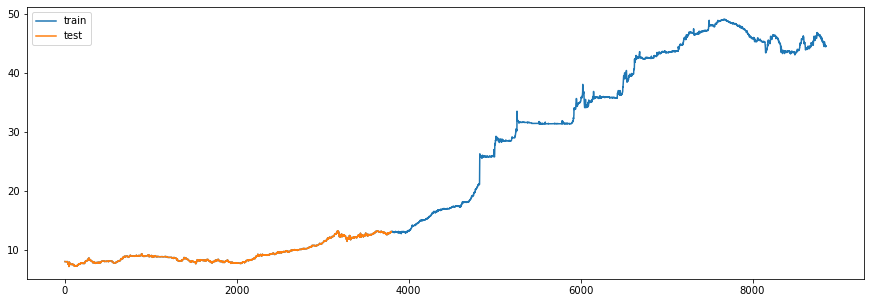

In [29]:
plt.figure(figsize=(15,5))
train['RATE'].plot(legend=True,label='train')
test['RATE'].plot(legend=True,label='test')

# Model Building

In [42]:
# there are 2 types of model building technique in forecasting.
    # 1.model based technique
    # 2.data driven model technique

In [43]:
# model based technique

In [27]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('RATE~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['RATE'])-np.array(pred_linear))**2))
rmse_linear

4.854463239627771

In [28]:
#Exponential

Exp = smf.ols('log_RATE~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['RATE'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

1.718431728792164

In [29]:
#Quadratic 

Quad = smf.ols('RATE~t+t_sqrt',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sqrt"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['RATE'])-np.array(pred_Quad))**2))
rmse_Quad

2.366171562651476

In [30]:
#Additive seasonality 

add_sea = smf.ols('RATE~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['RATE'])-np.array(pred_add_sea))**2))
rmse_add_sea

14.580415843716814

In [31]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('RATE~t+t_sqrt+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqrt']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['RATE'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

2.3661142659314183

In [32]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_RATE~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['RATE'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

9.695256688997336

In [33]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_RATE~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['RATE'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

1.717972307089095

In [34]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,1.717972
1,rmse_Exp,1.718432
4,rmse_add_sea_quad,2.366114
2,rmse_Quad,2.366172
0,rmse_linear,4.854463
5,rmse_Mult_sea,9.695257
3,rmse_add_sea,14.580416


In [35]:
# data driven model

In [36]:
#Evaluation Metric MAPE(mean absolute percentage error)
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [37]:
#simple exponential method
ses_model = SimpleExpSmoothing(train["RATE"]).fit(smoothing_level=0.8)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
MAPE(pred_ses,test.RATE)

0.2684763461825921

In [38]:
# Holt method 
hw_model = Holt(train["RATE"]).fit(smoothing_level=0.8,smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
MAPE(pred_hw,test.RATE) 

0.30439396216005365

In [39]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["RATE"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
MAPE(pred_hwe_add_add,test.RATE)

0.26747337308749564

In [40]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["RATE"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
MAPE(pred_hwe_mul_add,test.RATE)

0.25902484929231945

In [41]:
# the lowest MAPE value in above 4 models are Holts winter exponential smoothing with multiplicative seasonality and additive trend with the value is 0.2590

# ARIMA MODELS

In [34]:
from statsmodels.tsa.arima_model import ARIMA

In [28]:
model = ARIMA(df.RATE, order=(1,1,1))
model_fit = model.fit(disp=0)

In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.RATE   No. Observations:                12648
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4028.381
Method:                       css-mle   S.D. of innovations              0.176
Date:                Fri, 06 Aug 2021   AIC                          -8048.762
Time:                        14:15:37   BIC                          -8018.981
Sample:                             1   HQIC                         -8038.798
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0052      0.001      3.606      0.000       0.002       0.008
ar.L1.D.RATE     0.3962      0.084      4.734      0.000       0.232       0.560
ma.L1.D.RATE    -0.4405      0.082     -5.400      0.000      -0.600      -0.281
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5239           +0.0000j            2.5239            0.0000
MA.1            2.2701           +0.0000j            2.2701            0.0000
-----------------------------------------------------------------------------
"""

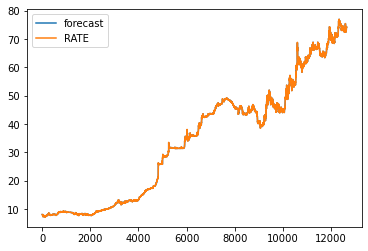

In [30]:
model_fit.plot_predict()
plt.show()

In [31]:
def ARIMA_Model(data,p,d,q):
    
    val = data.values
    val = val.astype('float32')
    train, test = val[1:len(val)-30], val[len(val)-30:]
    history = [x for x in train]
    predictions = list()
    
    for i in range(len(test)):
        arima_model = ARIMA(history, order=(p,d,q)).fit()
        output = arima_model.forecast()
        ypred = output[0]
        predictions.append(ypred)
        act = test[i]
        history.append(act)
        print('predicted=%f, expected=%f' % (ypred, act))
       
    # evaluate forecasts
    residuals = test - predictions 
    rmse = np.sqrt(np.mean(residuals**2))
    print('Root Mean Squared Error: %.3f' %rmse)
    mape = np.mean(abs(residuals/test))
    print('Mean Absolute Percentage Error: %.3f' %mape)
    
    #Print summary of the model
    print(arima_model.summary())
    
    # plot forecasts against actual outcomes
    forecast=arima_model.forecast(steps=30,alpha=0.05)[0]
    arima_model.plot_predict()
    arima_model.plot_predict(12619,12649)

In [ ]:
ARIMA_Model(df,1,1,1)

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [29]:
def AR_Model(data):
    series = data
    val = series.values
    train, test = val[1:len(val)-30], val[len(val)-30:]
    
    #Create Model
    start = time()
    ar_model = AutoReg(train, lags=2).fit()
    end = time()
    print("Model fitting time:", end-start)
    print('Coefficients: %s' % ar_model.params)
    
    #Print summary of the model
    print(ar_model.summary())
    
    #Get the predictions
    predictions = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    residuals = test - predictions
    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    rmse = np.sqrt(np.mean(residuals**2))
    print('Root Mean Squared Error: %.3f' %rmse)
    mape = round(np.mean(abs(residuals/test)),4)
    print('Mean Absolute Percentage Error:', mape)
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(test)
    plt.plot(predictions)
    
    plt.legend(('Actual','Prediction'), fontsize=16)
    plt.title('USD-INR Rate Change over time', fontsize=20)
    plt.ylabel('Rate', fontsize=16)